In [67]:
import matplotlib.pyplot as plt

In [3]:
names = open("../makemore/names.txt").read().splitlines()
len(names)

32033

In [10]:
stoi = {c: idx for idx, c in enumerate(['.'] + sorted(set(list(''.join(names)))))}
itos = {i: c for c, i in stoi.items()}

In [20]:
import torch
def build_dataset(words, block_size = 3): 
    x, y = [], []
    for word in words:
        context = [0] * block_size
        for c in list(word) + ['.']: 
            x.append(list(context))
            y.append(stoi[c])
            context = context[1:] + [stoi[c]]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    print(X.shape, Y.shape)
    return X, Y
x, y = build_dataset(names)

torch.Size([228146, 3]) torch.Size([228146])


In [137]:
import random
random.seed(42)
random.shuffle(names)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr,  Ytr  = build_dataset(names[:n1])     # 80%
Xdev, Ydev = build_dataset(names[n1:n2])   # 10%
Xte,  Yte  = build_dataset(names[n2:])     # 10%

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [138]:
from torch import nn
import torch.nn.functional as F

In [155]:
n_emb = 10
n_hidden = 200
vocab_size = 27
block_size = 3
model = nn.Sequential(
    nn.Embedding(vocab_size, n_emb),
    nn.Flatten(start_dim=1),
    nn.Linear(n_emb * block_size, n_hidden),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, vocab_size)
)

with torch.no_grad():
    model[2].weight *= 5/3  # scale first Linear's weights
    model[2].bias.zero_()
    model[5].weight.zero_()  # output layer
    model[5].bias.zero_()


In [156]:
sum(p.numel() for p in model.parameters())

12297

In [157]:
torch.manual_seed(42)

In [158]:
epochs = 200000
lossi = []
model.train()
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    logits = model(Xtr[ix])
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # set grad
    for p in model.parameters(): 
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01

    for p in model.parameters(): 
        p.data += -lr * p.grad
    lossi.append(loss.log10().item())        

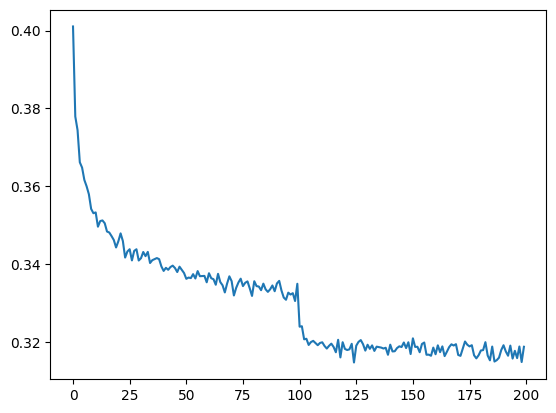

In [159]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [160]:
@torch.no_grad
def split_loss(t): 
    x, y = {
        'train': (Xtr, Ytr), 
        'dev': (Xdev, Ydev),
        'val': (Xte, Yte)
    }[t]
    model.eval()
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(t, loss.item())
    return loss
split_loss('train')
split_loss('val')

train 2.0611088275909424
val 2.120359420776367


tensor(2.1204)

In [161]:
# Sample 10 names
model.eval()
for i in range(10): 
    context = [0] * block_size
    out = []
    
    while True: 
        x = torch.tensor([context])
        
        with torch.no_grad():
            logits = model(x)
        probs = F.softmax(logits, dim = -1)
        ix = torch.multinomial(probs, num_samples=1).item()
        if ix == 0: 
            break
        
        out.append(ix)
        context = context[1:] + [ix]
        
        
    print(''.join(itos[i] for i in out))

everince
tyta
irha
zzair
den
hella
kel
chailyah
trulie
hel
